In [1]:
import torch
import numpy as np 
import pandas as pd

In [2]:
from pathlib import Path

In [3]:
import os
import cv2

In [4]:
class PediCXRDataset(torch.utils.data.Dataset):
    def __init__(self,data_dir, phase, transform, merge_disease = True,seed = 42):
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        # '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/vindr-pcxr/1.0.0'
        self.dir_root = data_dir
        self.set_type = phase
        self.transform = transform
        self.label_columns = ['Brocho-pneumonia','Bronchiolitis','Bronchitis','CPAM',
                              'Congenital emphysema','Diagphramatic hernia','Hyaline membrane disease','Lung tumor',
                              'Mediastinal tumor','No finding','Other disease','Pleuro-pneumonia','Pneumonia','Situs inversus','Tuberculosis']

        # generate labels
        meta_file_name = f'image_labels_{self.set_type}.csv'
        annotation_file_name = f'annotations_{self.set_type}.csv'
        self.meta_df = pd.read_csv(os.path.join(self.dir_root,meta_file_name))
        self.labels = self.meta_df[self.label_columns]
        self.labels = self.labels.fillna(0)
        self.labels = self.labels.replace(-1, 0)
        
        if merge_disease:
            kept_labels = ['Brocho-pneumonia','Bronchiolitis','Bronchitis','Pneumonia','No finding'] 
            diseases_to_combine = list(set(self.label_columns) - set(kept_labels))
            merged_labels = self.labels.copy()
            merged_labels['Other diseases'] = 0
            for disease in diseases_to_combine:
                if disease in merged_labels.columns:
                    merged_labels['Other diseases'] += merged_labels[disease]
                    merged_labels[disease] = 0
                else:
                    continue
            merged_labels.drop(columns=diseases_to_combine, inplace=True, errors='ignore')
            merged_labels[merged_labels >= 1] = 1
            self.labels = merged_labels

        # generate annotations
        self.anno_df = pd.read_csv(os.path.join(self.dir_root,annotation_file_name))
        self.annotation = self.anno_df[['x_min', 'y_min', 'x_max', 'y_max']]
        
        
        # 
        
    def __len__(self):
        return self.meta_df.shape[0]
    
    def get_img_path(self,idx):
        row = self.meta_df.iloc[idx,:]
        image_name = str((row['image_id'])) + '.jpg'
        image_path = os.path.join(self.dir_root,self.set_type,image_name)
        self.jpg_name = Path(image_path)
        label = self.labels.iloc[idx,:]
        PI = self.annotation.iloc[idx,:]
        return self.jpg_name,label,PI        
        

    def __getitem__(self, idx):

        sample = {}
        sample["idx"] = idx
        
        img_path,label,PI = self.get_img_path(idx)
        sample['label'] = torch.tensor((list(label)),dtype=torch.long)
        sample['PI'] = torch.tensor(list(np.round(PI,3)),dtype=torch.float32)
        sample['img_path'] = img_path.__str__()

        # single channel output renormliazed to [0, 255]
        # img = imread(str(img_path), as_gray=True)
        img = cv2.imread(sample['img_path'])
        # img = cv2.resize(img, (224, 224))
        # img = np.float32(img) / 255
        if self.transform:
            sample["img"] = self.transform(img)
        else: 
            sample["img"] = img
        return sample

In [5]:
ROOT = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Processed/Yufeng/PediXR_Results'
DATASET_DIR="/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/vindr-pcxr/1.0.0" 

In [6]:
test_dataset = PediCXRDataset(data_dir=DATASET_DIR, phase='test', transform=None, merge_disease  = False)

In [7]:
len(test_dataset)

1397

In [8]:
test_dataset[0]['img'].shape

(1692, 1255, 3)

In [32]:
test_dataset.labels.sum()

Brocho-pneumonia             84.0
Bronchiolitis                90.0
Bronchitis                  174.0
CPAM                          1.0
Congenital emphysema          0.0
Diagphramatic hernia          0.0
Hyaline membrane disease      3.0
Lung tumor                    0.0
Mediastinal tumor             1.0
No finding                  907.0
Other disease                77.0
Pleuro-pneumonia              0.0
Pneumonia                    89.0
Situs inversus                2.0
Tuberculosis                  1.0
dtype: float64

In [29]:
test_dataset = PediCXRDataset(data_dir=DATASET_DIR, phase='test', transform=None, merge_disease  = True)
test_dataset.labels.sum()

Brocho-pneumonia     84.0
Bronchiolitis        90.0
Bronchitis          174.0
No finding          907.0
Pneumonia            89.0
Other diseases       81.0
dtype: float64

In [27]:
train_dataset = PediCXRDataset(data_dir=DATASET_DIR, phase='train', transform=None, merge_disease  = True)
train_dataset.labels.sum()

Brocho-pneumonia     545.0
Bronchiolitis        497.0
Bronchitis           842.0
No finding          5143.0
Pneumonia            392.0
Other diseases       463.0
dtype: float64

In [17]:
train_dataset = PediCXRDataset(data_dir=DATASET_DIR, phase='train', transform=None, merge_disease  = True)
train_dataset.labels.sum()

Brocho-pneumonia     545.0
Bronchiolitis        497.0
Bronchitis           842.0
No finding          5143.0
Pneumonia            392.0
Other diseases       463.0
dtype: float64

### calcualte other model stats

In [9]:
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
import matplotlib.pyplot as plt

In [12]:
ROOT = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Processed/Yufeng/PediXR_Results'

In [13]:
m_name = 'vit-b_CXR_0.5M_mae_CheXpert'
SAVE_DIR=os.path.join(ROOT,m_name)

In [14]:
nb_classes = 6

In [15]:
pred = np.load(os.path.join(SAVE_DIR,'y_pred.npy'))
y_test = np.load(os.path.join(SAVE_DIR,'y_gt.npy'))

In [47]:
# pred_index  = np.argmax(pred,axis = 1).reshape(-1)
# y_pred = np.eye(nb_classes)[pred_index]

In [97]:
y_pred = pred>0.4

In [98]:
# f, axes = plt.subplots(2, 3, figsize=(25, 15))
# axes = axes.ravel()
# for i in range(6):
#     disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
#                                                    y_pred[:, i]),
#                                   display_labels=['N', 'P'])
#     disp.plot(ax=axes[i], values_format='.4g')
#     disp.ax_.set_title(f'{list(train_dataset.labels.columns)[i]}')
#     if i != 4:
#         disp.ax_.set_xlabel('')
#     if i%3!=0:
#         disp.ax_.set_ylabel('')
#     disp.im_.colorbar.remove()

# plt.subplots_adjust(wspace=0.10, hspace=0.1)
# f.colorbar(disp.im_, ax=axes)
# plt.show()

In [21]:
y_pred = pred>0.1
spec = 0
prec = 0
f = 0
rec = 0
fpr_ls = 0
for i in range(6):
    tn, fp, fn, tp = confusion_matrix(y_test[:, i],y_pred[:, i]).ravel()
    precision = tp / (tp+fp)
    recall = tp/ (tp+fn)
    f1 = (precision*recall)*2/(precision+recall)
    specicity = tn /(tn + fp)
    fpr = fp/(fp+tn)
    fpr_ls += fpr
    rec +=recall
    f += f1
    prec += precision
    spec += specicity
    print(f'{list(train_dataset.labels.columns)[i]}, f1 score is {f1:.4f}; precision is {precision:.4f} and recall is {recall:.4f} and FPR is {fpr:.4f} and specicity is {specicity:.4f}.')
                                     

Brocho-pneumonia, f1 score is 0.2944; precision is 0.1871 and recall is 0.6905 and FPR is 0.1919 and specicity is 0.8081.
Bronchiolitis, f1 score is 0.2153; precision is 0.1372 and recall is 0.5000 and FPR is 0.2165 and specicity is 0.7835.
Bronchitis, f1 score is 0.3290; precision is 0.2128 and recall is 0.7241 and FPR is 0.3810 and specicity is 0.6190.
No finding, f1 score is 0.7984; precision is 0.6684 and recall is 0.9912 and FPR is 0.9102 and specicity is 0.0898.
Pneumonia, f1 score is 0.4264; precision is 0.3254 and recall is 0.6180 and FPR is 0.0872 and specicity is 0.9128.
Other diseases, f1 score is 0.1946; precision is 0.1420 and recall is 0.3086 and FPR is 0.1147 and specicity is 0.8853.


In [135]:
print(f'mf1 score is {f/6:.4f}; mprecision is {prec /6:.4f} and mrecall is {rec/6:.4f} and mspecificity is {spec/6:.4f}.')

mf1 score is 0.3763; mprecision is 0.2788 and mrecall is 0.6387 and mspecificity is 0.3169.


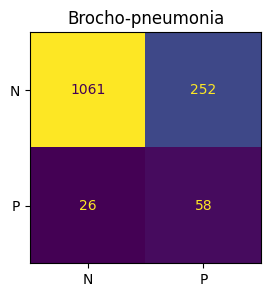

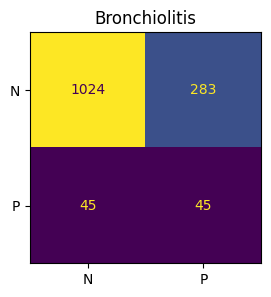

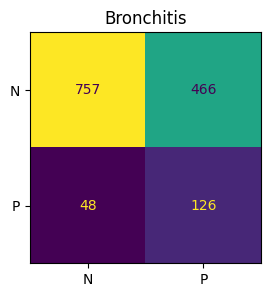

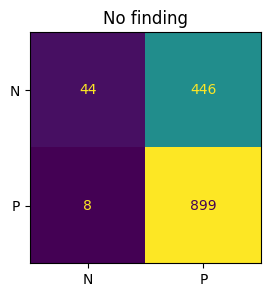

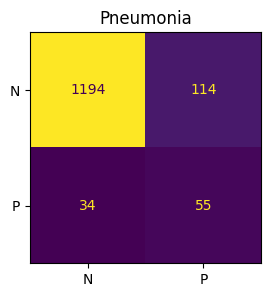

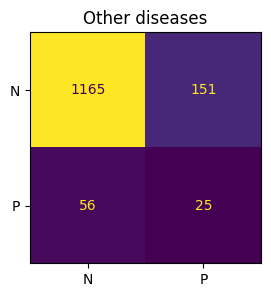

In [130]:
# f, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.ravel()
for i in range(6):
    f, ax = plt.subplots(figsize=(3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                   y_pred[:, i]),
                                  display_labels=['N', 'P'])
    disp.plot(ax=ax, values_format='.4g')
    disp.ax_.set_title(f'{list(train_dataset.labels.columns)[i]}')
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
    plt.savefig(f'./Figs/confusionmat_{list(train_dataset.labels.columns)[i]}.pdf',dpi=300,bbox_inches='tight')
    # plt.show()
# plt.subplots_adjust(wspace=0.10, hspace=0.1)
# f.colorbar(disp.im_, ax=axes)
# plt.savefig('./Figs/confusionmat..pdf',bbox_inches='tight')
# 